In [2]:
! kaggle datasets download -d alxmamaev/flowers-recognition


  0%|          | 0.00/225M [00:00<?, ?B/s]
  0%|          | 1.00M/225M [00:00<02:51, 1.37MB/s]
  1%|          | 2.00M/225M [00:00<01:33, 2.50MB/s]
  1%|▏         | 3.00M/225M [00:01<01:01, 3.77MB/s]
  2%|▏         | 4.00M/225M [00:01<00:51, 4.50MB/s]
  2%|▏         | 5.00M/225M [00:01<00:45, 5.09MB/s]
  3%|▎         | 6.00M/225M [00:01<00:41, 5.53MB/s]
  3%|▎         | 7.00M/225M [00:01<00:37, 6.01MB/s]
  4%|▎         | 8.00M/225M [00:01<00:33, 6.71MB/s]
  4%|▍         | 9.00M/225M [00:01<00:32, 7.06MB/s]
  4%|▍         | 10.0M/225M [00:02<00:30, 7.43MB/s]
  5%|▍         | 11.0M/225M [00:02<00:36, 6.19MB/s]
  6%|▌         | 13.0M/225M [00:02<00:34, 6.39MB/s]
  7%|▋         | 15.0M/225M [00:02<00:26, 8.26MB/s]
  7%|▋         | 16.0M/225M [00:02<00:27, 8.07MB/s]
  8%|▊         | 17.0M/225M [00:03<00:27, 8.01MB/s]
  8%|▊         | 18.0M/225M [00:03<00:26, 8.24MB/s]
  8%|▊         | 19.0M/225M [00:03<00:29, 7.24MB/s]
  9%|▉         | 20.0M/225M [00:03<00:27, 7.80MB/s]
  9%|▉         | 21.

In [4]:
from zipfile import ZipFile

data_ds_path = './flowers-recognition.zip'
with ZipFile(data_ds_path, 'r') as zip:
    zip.extractall()
    print('Data-Sets is extracted')


Data-Sets is extracted


In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model

In [6]:
tf.get_logger().setLevel('ERROR')

In [7]:
count = 0
dirs = os.listdir('./flowers/')
for dir in dirs:
    files = list(os.listdir('flowers/'+dir))
    print(dir + 'with ' + str(len(files)) + 'image')
    count = count+ len(files)
print(f'The total images equal to: {str(count)}')

daisywith 764image
dandelionwith 1052image
rosewith 784image
sunflowerwith 733image
tulipwith 984image
The total images equal to: 4317


In [8]:
IMG_SIZE = 180
BATCH_SIZE= 32

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./flowers',
    seed=42,
    validation_split=0.2,
    subset='training',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory= './flowers',
    seed=42,
    validation_split=0.2,
    subset='validation',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [10]:
flowers_names = train_ds.class_names
flowers_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

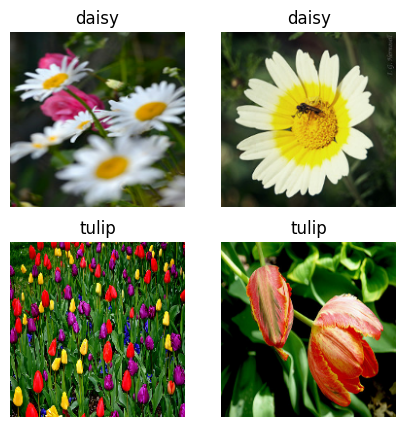

In [11]:
idx = 0
plt.figure(figsize=(5, 5))

for img, label in train_ds.take(1):
    for idx  in range(4):
        plt.subplot(2, 2, idx+1)
        plt.imshow(img[idx].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(flowers_names[label[idx]])

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)

In [14]:
val_ds = val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [15]:
# Image augmentation

data_aug = Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

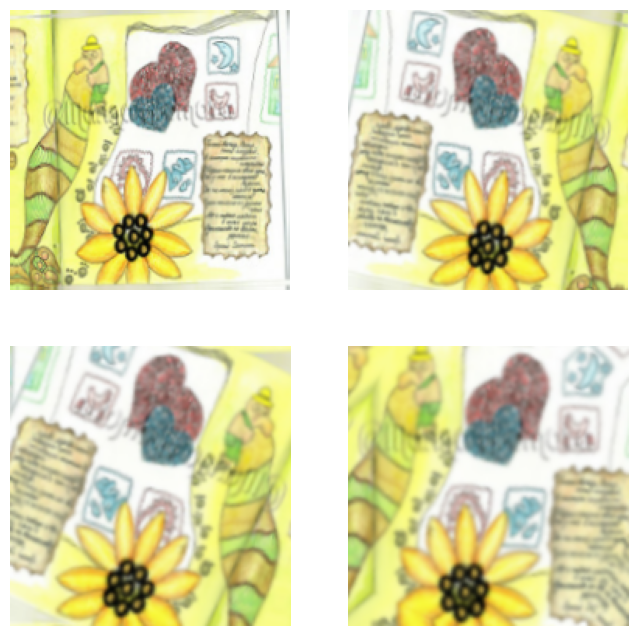

In [16]:
idx = 0
plt.figure(figsize=(8, 8))

for img, label in train_ds.take(1):
    for idx in range(4):
        img = data_aug(img)
        plt.subplot(2, 2, idx+1)
        plt.imshow(img[0].numpy().astype('uint8'))
        plt.axis('off')


In [17]:
len(flowers_names)

5

In [44]:
model = Sequential([
    data_aug,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(flowers_names))

])

In [45]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

In [46]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [47]:
history = model.fit(x=train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


108/108 [==============================] - 29s 242ms/step - loss: 1.4313 - accuracy: 0.4299 - val_loss: 1.4492 - val_accuracy: 0.4334
Epoch 2/20
108/108 [==============================] - 27s 253ms/step - loss: 1.0576 - accuracy: 0.5924 - val_loss: 0.9702 - val_accuracy: 0.6025
Epoch 3/20
108/108 [==============================] - 26s 240ms/step - loss: 0.9359 - accuracy: 0.6314 - val_loss: 1.0274 - val_accuracy: 0.6049
Epoch 4/20
108/108 [==============================] - 28s 258ms/step - loss: 0.8710 - accuracy: 0.6555 - val_loss: 0.8701 - val_accuracy: 0.6524
Epoch 5/20
108/108 [==============================] - 27s 252ms/step - loss: 0.8128 - accuracy: 0.6946 - val_loss: 0.8352 - val_accuracy: 0.6709
Epoch 6/20
108/108 [==============================] - 27s 251ms/step - loss: 0.7707 - accuracy: 0.7012 - val_loss: 0.9663 - val_accuracy: 0.6628
Epoch 7/20
108/108 [==============================] - 26s 237ms/step - loss: 0.7295 - accuracy: 0.7270 - val_loss: 0.8626 - val_accuracy: 0.6

In [62]:
def predict_img(img_path):
    input_img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    input_img_array = tf.keras.utils.img_to_array(input_img)
    input_img_exp_dim = tf.expand_dims(input_img_array, 0)

    pred = model.predict(input_img_exp_dim)
    result = tf.nn.softmax(pred[0])
    plt.imshow(input_img)
    plt.title(flowers_names[np.argmax(result)])
    plt.axis('off')

1/1 [==============================] - 0s 24ms/step


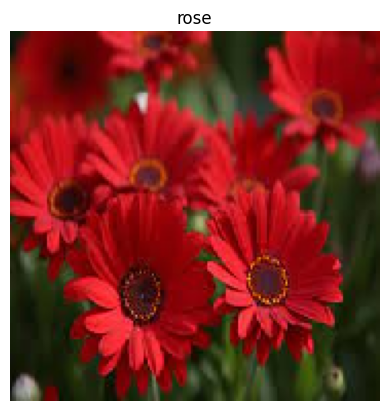

In [63]:
predict_img('./images.jpg')

1/1 [==============================] - 0s 22ms/step


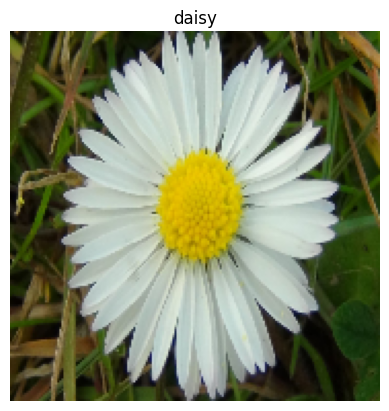

In [64]:
predict_img('./Daisy-flower.jpg')

In [65]:
model.save('model_11-2024.h5')